<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/3_PyTorchNeuralNetwork/MNIST_RandomNumber_Addition.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Addition of two numbers using neural network

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import random

In [58]:
## Creation of Random MNIST dataset

from torch.utils.data import Dataset
import random

class RandomMNISTDataset(Dataset):
  def __init__(self, MNISTDataset):
    self.MNISTDataset = MNISTDataset

  def __getitem__(self, index):
    image = self.MNISTDataset[index][0]
    label = self.MNISTDataset[index][1]
    randomNo = random.randint(0,9)
    sum = label + randomNo
    return image, label, randomNo, sum

  def __len__(self):
    return len(self.MNISTDataset)

In [59]:
# torchvision.datasets.MNIST outputs a set of PIL images
# We transform them to tensors
transform = transforms.ToTensor()

# Load and transform data
MNIST_trainset = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=transform)
MNIST_testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=transform)

In [60]:
train_dataset = RandomMNISTDataset(MNIST_trainset)
test_dataset = RandomMNISTDataset(MNIST_testset)

In [61]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset,batch_size=128,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=128)

### Visualization of a batch

Labels:  tensor([2, 2, 8, 4, 4, 5, 5, 3, 8, 2, 4, 3, 7, 9, 5, 7, 0, 7, 9, 4, 1, 8, 5, 8,
        5, 5, 9, 4, 0, 7, 8, 9, 4, 7, 8, 9, 0, 2, 5, 0, 9, 5, 1, 8, 9, 9, 4, 3,
        9, 5, 7, 5, 0, 3, 6, 9, 7, 1, 7, 0, 4, 8, 2, 3, 1, 4, 9, 2, 9, 3, 4, 3,
        3, 6, 4, 1, 2, 1, 8, 5, 0, 0, 6, 0, 0, 1, 6, 4, 2, 4, 8, 5, 4, 4, 3, 8,
        4, 7, 5, 7, 7, 2, 9, 2, 4, 7, 6, 1, 9, 0, 7, 8, 3, 7, 8, 2, 5, 6, 7, 8,
        0, 6, 1, 4, 0, 9, 2, 6])
Random Numbers:  tensor([3, 8, 2, 6, 0, 9, 4, 7, 2, 0, 6, 7, 2, 0, 1, 1, 6, 6, 0, 3, 5, 6, 5, 8,
        8, 1, 4, 5, 6, 5, 3, 2, 2, 6, 5, 1, 1, 7, 5, 4, 4, 8, 2, 8, 2, 3, 9, 1,
        7, 6, 1, 1, 0, 7, 2, 8, 2, 6, 7, 5, 5, 8, 6, 5, 8, 0, 9, 6, 9, 8, 0, 5,
        0, 0, 1, 6, 6, 3, 4, 5, 7, 1, 3, 4, 1, 5, 9, 9, 5, 7, 2, 8, 8, 6, 8, 8,
        3, 5, 3, 4, 9, 1, 8, 3, 7, 7, 2, 8, 2, 4, 8, 4, 9, 2, 5, 6, 9, 1, 3, 2,
        7, 0, 8, 3, 7, 1, 3, 3])
Sum:  tensor([ 5, 10, 10, 10,  4, 14,  9, 10, 10,  2, 10, 10,  9,  9,  6,  8,  6, 13,
         9,  7,  6, 14

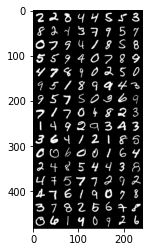

In [62]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

dataiter = iter(train_loader)
images, labels, randomNumbers, sums = dataiter.next()

show_batch(images)
print('Labels: ', labels)
print('Random Numbers: ', randomNumbers)
print('Sum: ', sums)



### Defining Network

In [102]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)       #Input: 28*28*1    Output:28 * 28 * 32    GRF:3 * 3  (GRF - Global Receptive Field)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)      #Input: 28*28*32   Output:28 * 28 * 64    GRF:5 * 5
        self.pool1 = nn.MaxPool2d(2, 2)                   #Input: 28*28*64   Output:14 * 14 * 64    GRF:10*10 (for now we are considering that with max pooling, receptive field doubles - but this is not entirely correct)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)     #Input: 14*14*64   Output:14 * 14 * 128   GRF:12*12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)    #Input: 14*14*128  Output:14 * 14 * 256   GRF:14*14
        self.pool2 = nn.MaxPool2d(2, 2)                   #Input: 14*14*256  Output: 7 * 7 * 256    GRF:28*28
        self.conv5 = nn.Conv2d(256, 512, 3)               #Input: 7*7*256    Output: 5 * 5 * 12     GRF:30*30
        self.conv6 = nn.Conv2d(512, 1024, 3)              #Input: 5*5*12     Output: 3 * 3 * 1024   GRF:32*32
        self.conv7 = nn.Conv2d(1024, 10, 3)               #Input: 3*3*1024   Output: 1 * 1 * 10     GRF:34*34

        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 30)
        self.fc2 = nn.Linear(30, 18)

    def forward(self, image, randomNumber):
        #The first convolutional layer self.conv1 has a convolutional operation on input tensor x, followed by a relu activation operation 
        #whcih is then passed to second convolution operation self.conv2 followed by a relu whose output is then passed to a max pooling 
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(image)))))

        #The output of the max pool operation is passed to another two convolution and relu activation operation followed by max pooling. 
        #The relu() and the max_pool2d() calls are just pure operations. Neither of these have weights  
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))

        #The output of the max pool operation from 4th convolution is passed to another two sets of convolution and relu activation operation
        x = F.relu(self.conv6(F.relu(self.conv5(x))))

        # The output from 6th convolution is then passed to a linear layer
        x = F.linear(self.conv7(x), 10)

        #The flatten's all of the tensor's elements into a single dimension.
        x = x.view(-1, 10)

        x1 = F.linear(self.fc1(torch.Tensor(randomNumber)))      

        #The flatten's all of the tensor's elements into a single dimension.
        x1 = torch.cat((x, x1), dim=1)

        x1 = F.linear(self.fc2(x1)) 
        x1 = F.linear(self.fc3(x1))     

        #The flatten's all of the tensor's elements into a single dimension.
        x1 = x1.view(-1, 18)

        # Inside the network we usually use relu() as our non-linear activation function, but for the output layer, we use Softmax function for predicting category with maximum probability. 
        #The softmax function returns a positive probability for each of the prediction classes, and the values sum to 1.
        return F.log_softmax(x), F.log_softmax(x1)

In [103]:
!pip install torchsummary
from torchsummary import summary

#This command will return a boolean (True/False) based on the GPU availability.
use_cuda = torch.cuda.is_available()                   #Checking if GPU is available

#use the use_cuda flag to specify which device you want to use
# This will set the device to the GPU if one is available and to the CPU if there isn’t a GPU available. This means that you don’t need to hard code changes into your code to use one or the other.
device = torch.device("cuda" if use_cuda else "cpu") 

#move the model to the choosen device
model = Net().to(device)      

# prints the model summary
#summary(model, [(1, 28, 28),(1,1)])                #Gray scale images hence its only 1 channel

print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(1024, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=30, out_features=18, bias=True)
)


In [104]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

#load train data and normalize the pixel values with mean and std computed on the MNIST training set
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset,batch_size=128,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=128)

In [105]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target, randomNumber, sum) in enumerate(pbar):
        data, target, randomNumber, sum = data.to(device), target.to(device), randomNumber.to(device), sum.to(device)
        optimizer.zero_grad()
        output, sum_output = model(data, randomNumber)
        MNIST_loss = F.nll_loss(output, target)
        sum_loss = F.nll_loss(sum_output, sum)
        loss = MNIST_loss + sum_loss
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

In [106]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target, randomNumber, sum in test_loader:
            data, target, randomNumber, sum = data.to(device), target.to(device), randomNumber.to(device), sum.to(device)
            output, sum_output = model(data, randomNumber)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += F.nll_loss(sum_output, sum, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [107]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 2):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)






  0%|          | 0/469 [00:00<?, ?it/s]

TypeError: ignored